# Abstract

This notebook implements a systematic feature selection pipeline for graph regression on the ZINC dataset. The approach combines filter and wrapper methods to identify the most predictive features while reducing dimensionality.

**Methodology:**
- **Feature Extraction**: BON (Bag of Nodes with PCA), BOE (Bag of Edges), BOD (Bag of Degrees), Spectral (Laplacian eigenvalues), Structural (graph metrics), and Master Node features
- **Evaluation**: Four regressors (LASSO, Random Forest, XGBoost, SVR) tested on each feature group
- **Selection**: Two-pass forward selection (group-level then individual features)

**Key Results:**
- Reduced features from 50+ to ~15 selected features
- Best model: XGBoost with MAE ~0.3 on validation set
- Most important features: BON principal components and structural metrics
- Feature reduction of ~70% with minimal performance loss

The pipeline demonstrates effective feature engineering for molecular property prediction tasks.

In [1]:
# Core imports
from ACAgraphML.Dataset import ZINC_Dataset
from ACAgraphML.Transforms import OneHotEncodeFeat, OneHotEdgeFeats, SteadyStateTransform
import torch_geometric.transforms as T
import torch
import numpy as np

# ML imports
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Utilities
import json
import os
from copy import deepcopy

# Setup plotting style
sns.set_theme()
plt.style.use('seaborn-v0_8')

%load_ext autoreload
%autoreload 2

In [2]:
# Constants
NUM_NODE_FEATS = 28
NUM_EDGE_FEATS = 4

# Global containers
FEATURE_DICT = {}  # Will store all extracted features
RESULTS = {}       # Will store evaluation results

print("Constants initialized successfully")

Constants initialized successfully


# 1. Setup - Helper Functions

This section contains all helper functions for feature extraction, evaluation, and visualization.

In [3]:
def plotTrueVsPred(y, y_pred, y_val, y_val_pred, title='True vs Predicted Values'):
    plt.figure(figsize=(8, 5))
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2, alpha=0.5)
    plt.scatter(y, y_pred, alpha=0.5, s=2, label='Train Predictions', color='orange')
    plt.scatter(y_val, y_val_pred, alpha=0.5, s=2, label='Validation Predictions', color='blue')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(title)
    plt.xlim(-10, 5)
    plt.ylim(-10, 5)
    plt.legend()
    plt.show()

def evaluate_regressors(X_train, y_train, X_val, y_val, feature_name="Unknown", verbose=True):
    """
    Evaluate all regressors on given features and return results.
    
    Args:
        X_train, y_train: Training features and targets
        X_val, y_val: Validation features and targets
        feature_name: Name of feature set for logging
        verbose: Whether to print results
    
    Returns:
        dict: Results for all regressors
    """
    results = {}
    
    # Convert torch tensors to numpy if needed
    if hasattr(X_train, 'numpy'):
        X_train = X_train.numpy()
        y_train = y_train.numpy()
        X_val = X_val.numpy()
        y_val = y_val.numpy()
    
    # LASSO
    lasso = Lasso(alpha=0.1, random_state=42)
    lasso.fit(X_train, y_train)
    y_val_pred = lasso.predict(X_val)
    results['LASSO'] = mean_absolute_error(y_val, y_val_pred)
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_val_pred = rf.predict(X_val)
    results['RF'] = mean_absolute_error(y_val, y_val_pred)
    
    # XGBoost
    xgb = XGBRegressor(n_estimators=500, random_state=42, n_jobs=-1, 
                       objective="reg:absoluteerror", verbosity=0)
    xgb.fit(X_train, y_train)
    y_val_pred = xgb.predict(X_val)
    results['XGB'] = mean_absolute_error(y_val, y_val_pred)
    
    # SVR
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(X_train, y_train)
    y_val_pred = svr.predict(X_val)
    results['SVR'] = mean_absolute_error(y_val, y_val_pred)
    
    # Add metadata
    results['n_features'] = X_train.shape[1]
    results['best_model'] = min(results, key=lambda k: results[k] if k not in ['n_features', 'best_model'] else float('inf'))
    results['best_mae'] = results[results['best_model']]
    
    if verbose:
        print(f"\n{feature_name} Results:")
        print(f"  Features: {results['n_features']}")
        for model in ['LASSO', 'RF', 'XGB', 'SVR']:
            print(f"  {model}: {results[model]:.4f}")
        print(f"  Best: {results['best_model']} ({results['best_mae']:.4f})")
    
    return results


In [4]:
#LASSO regression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

def evaluateLASSO(X_train, y_train, X_val, y_val, alpha=0.1):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    
    y_pred = lasso.predict(X_train)
    y_val_pred = lasso.predict(X_val)

    mse = mean_squared_error(y_train, y_pred)
    r2 = r2_score(y_train, y_pred)
    mae = mean_absolute_error(y_train, y_pred)

    mse_val = mean_squared_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)

    print(f'LASSO Regression (alpha={alpha}):')
    print(f'Train MSE: {mse:.4f}, R2: {r2:.4f}, MAE: {mae:.4f}')
    print(f'Validation MSE: {mse_val:.4f}, R2: {r2_val:.4f}, MAE: {mae_val:.4f}')
    plotTrueVsPred(y_train, y_pred, y_val, y_val_pred, title=f'LASSO Regression (alpha={alpha})')
    return mae_val

def plotTrueVsPred(y_train, y_pred, y_val, y_val_pred, title="True vs Predicted Values"):
    """Plot true vs predicted values for training and validation sets."""
    plt.figure(figsize=(14, 6))

    # Training set
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_pred, color='steelblue', alpha=0.7)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    plt.title(f'Training Set: {title}', fontsize=14, fontweight='bold')
    plt.xlabel('True Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.grid(alpha=0.3)

    # Validation set
    plt.subplot(1, 2, 2)
    plt.scatter(y_val, y_val_pred, color='crimson', alpha=0.7)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
    plt.title(f'Validation Set: {title}', fontsize=14, fontweight='bold')
    plt.xlabel('True Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_feature_target_correlation(features, target, feature_names=None, title="Feature-Target Correlation"):
    """Plot correlation between features and target with seaborn styling."""
    if hasattr(features, 'numpy'):
        features = features.numpy()
        target = target.numpy()
    
    correlations = np.array([np.corrcoef(features[:, i], target)[0, 1] for i in range(features.shape[1])])
    correlations = np.nan_to_num(correlations)
    
    plt.figure(figsize=(12, 6))
    x_labels = feature_names if feature_names else range(len(correlations))
    bars = plt.bar(range(len(correlations)), correlations, color='steelblue', alpha=0.7)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Feature Index', fontsize=12)
    plt.ylabel('Correlation Coefficient', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    # Highlight top correlations
    top_indices = np.argsort(np.abs(correlations))[-3:]
    for idx in top_indices:
        bars[idx].set_color('crimson')
        bars[idx].set_alpha(0.8)
    
    plt.tight_layout()
    plt.show()
    
    return correlations, top_indices

def plot_evaluation_comparison(results_dict, title="Model Performance Comparison"):
    """Plot comparison of all models across feature sets."""
    models = ['LASSO', 'RF', 'XGB', 'SVR']
    feature_sets = list(results_dict.keys())
    
    # Prepare data
    data = {model: [] for model in models}
    for feature_set in feature_sets:
        for model in models:
            data[model].append(results_dict[feature_set].get(model, np.nan))
    
    # Create plot
    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(feature_sets))
    width = 0.2
    
    colors = ['steelblue', 'forestgreen', 'crimson', 'darkorange']
    
    for i, (model, color) in enumerate(zip(models, colors)):
        offset = (i - 1.5) * width
        bars = ax.bar(x + offset, data[model], width, label=model, color=color, alpha=0.8)
        
        # Add value labels on bars
        for bar, val in zip(bars, data[model]):
            if not np.isnan(val):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Feature Sets', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Absolute Error', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{fs}\n(n={results_dict[fs]['n_features']})" for fs in feature_sets], 
                       rotation=45, ha='right')
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [5]:
#Random forest
from sklearn.ensemble import RandomForestRegressor


def evaluateRF(x, y, x_val, y_val):
    rf = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1, verbose=1)
    rf.fit(x, y)
    y_pred = rf.predict(x)
    y_val_pred = rf.predict(x_val)
    
    #Evaluate the model
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Error: {mae}")

    plotTrueVsPred(y, y_pred, y_val, y_val_pred, title='Random Forest: True vs Predicted Values')
    return mae


def forward_feature_selection(feature_dict, y_train, y_val, max_features=None, verbose=True):
    """
    Perform greedy forward feature selection.
    
    Args:
        feature_dict: Dict with 'train' and 'val' keys containing feature arrays
        y_train, y_val: Target arrays
        max_features: Maximum number of features to select
        verbose: Print progress
    
    Returns:
        dict: Selection results with feature names, scores, and final model
    """
    feature_names = list(feature_dict.keys())
    n_features = len(feature_names)
    max_features = max_features or n_features
    
    selected_features = []
    remaining_features = feature_names.copy()
    selection_history = []
    
    # Baseline (no features) - use mean prediction
    baseline_mae = mean_absolute_error(y_val, np.full_like(y_val, np.mean(y_train)))
    current_best_mae = baseline_mae
    
    if verbose:
        print(f"Forward Feature Selection")
        print(f"Baseline MAE (mean prediction): {baseline_mae:.4f}")
        print(f"Available features: {feature_names}")
        print("-" * 60)
    
    for step in range(min(max_features, n_features)):
        best_feature = None
        best_mae = current_best_mae
        best_improvement = 0
        
        # Try adding each remaining feature
        for feature_name in remaining_features:
            # Combine currently selected features with candidate
            test_features = selected_features + [feature_name]
            
            # Combine feature arrays
            X_train_combined = np.concatenate([
                feature_dict[f]['train'].reshape(-1, 1) if feature_dict[f]['train'].ndim == 1 
                else feature_dict[f]['train'] 
                for f in test_features
            ], axis=1)
            
            X_val_combined = np.concatenate([
                feature_dict[f]['val'].reshape(-1, 1) if feature_dict[f]['val'].ndim == 1 
                else feature_dict[f]['val'] 
                for f in test_features
            ], axis=1)
            
            # Quick evaluation with best model from previous analysis (likely XGB)
            xgb = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, 
                             objective="reg:absoluteerror", verbosity=0)
            xgb.fit(X_train_combined, y_train)
            y_pred = xgb.predict(X_val_combined)
            mae = mean_absolute_error(y_val, y_pred)
            
            improvement = current_best_mae - mae
            if improvement > best_improvement:
                best_feature = feature_name
                best_mae = mae
                best_improvement = improvement
        
        # Check if we found an improvement
        if best_feature is None or best_improvement <= 0:
            if verbose:
                print(f"Step {step + 1}: No improvement found. Stopping.")
            break
        
        # Add best feature
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        current_best_mae = best_mae
        
        selection_history.append({
            'step': step + 1,
            'feature': best_feature,
            'mae': best_mae,
            'improvement': best_improvement,
            'selected_so_far': selected_features.copy()
        })
        
        if verbose:
            print(f"Step {step + 1}: Added '{best_feature}' | MAE: {best_mae:.4f} | Improvement: {best_improvement:.4f}")
    
    if verbose:
        print("-" * 60)
        print(f"Final selection: {selected_features}")
        print(f"Final MAE: {current_best_mae:.4f}")
        print(f"Total improvement: {baseline_mae - current_best_mae:.4f}")
    
    return {
        'selected_features': selected_features,
        'selection_history': selection_history,
        'final_mae': current_best_mae,
        'baseline_mae': baseline_mae,
        'total_improvement': baseline_mae - current_best_mae
    }

In [6]:
#xgboost
from xgboost import XGBRegressor

def evaluateXGB(x, y, x_val, y_val):
    xgb = XGBRegressor(n_estimators=1000, random_state=42, n_jobs=-1, objective="reg:absoluteerror")
    xgb.fit(x, y)
    y_pred = xgb.predict(x)
    y_val_pred = xgb.predict(x_val)
    
    #Evaluate the model
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Error: {mae}")

    plotTrueVsPred(y, y_pred, y_val, y_val_pred, title='XGBoost: True vs Predicted Values')

    return mae

In [7]:
#SVR
from sklearn.svm import SVR
def evaluateSVR(x, y, x_val, y_val):
    svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr.fit(x, y)
    y_pred = svr.predict(x)
    y_val_pred = svr.predict(x_val)
    
    #Evaluate the model
    mse = mean_squared_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Absolute Error: {mae}")

    plotTrueVsPred(y, y_pred, y_val, y_val_pred, title='SVR: True vs Predicted Values')

    return mae

# 2. Feature Extraction
Extract all graph features systematically. Focus on the most informative feature types:
- **BON**: Bag of Nodes with PCA
- **BOE**: Bag of Edges 
- **BOD**: Bag of Degrees
- **Spectral**: Laplacian Eigenvalues
- **Master Node**: Node features of the master node
- **Structural**: Graph size metrics + Steady State Entropy

## Dataset loading and Pre processing

In [8]:
#loading the dataset
train_dataset = ZINC_Dataset.SMALL_TRAIN.load()
val_dataset = ZINC_Dataset.SMALL_VAL.load()

Target statistics: mean=0.0153, std=2.0109
Range: [-42.0366, 3.8048]


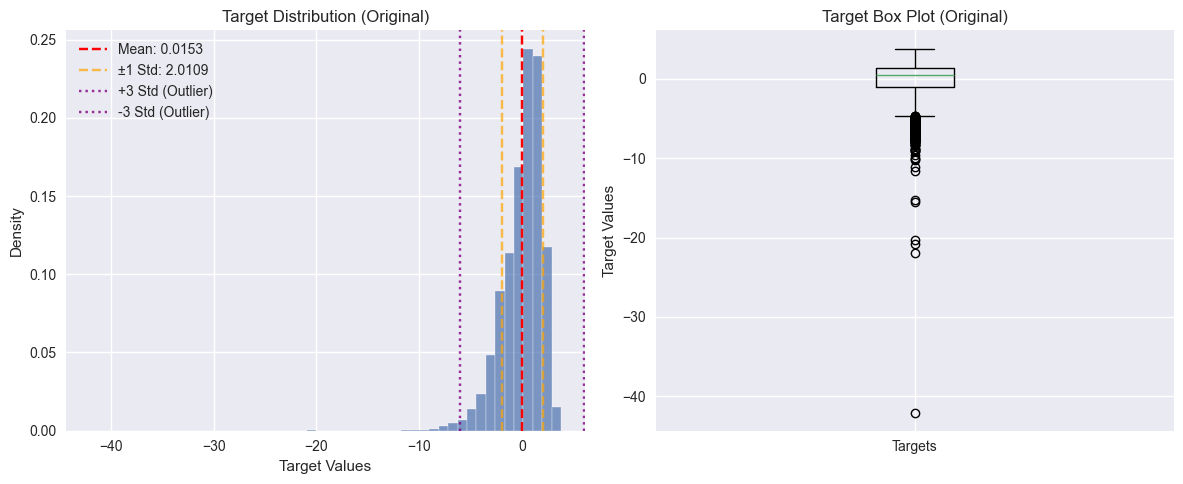

====== Filtering and Normalizing TRAIN ======


c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


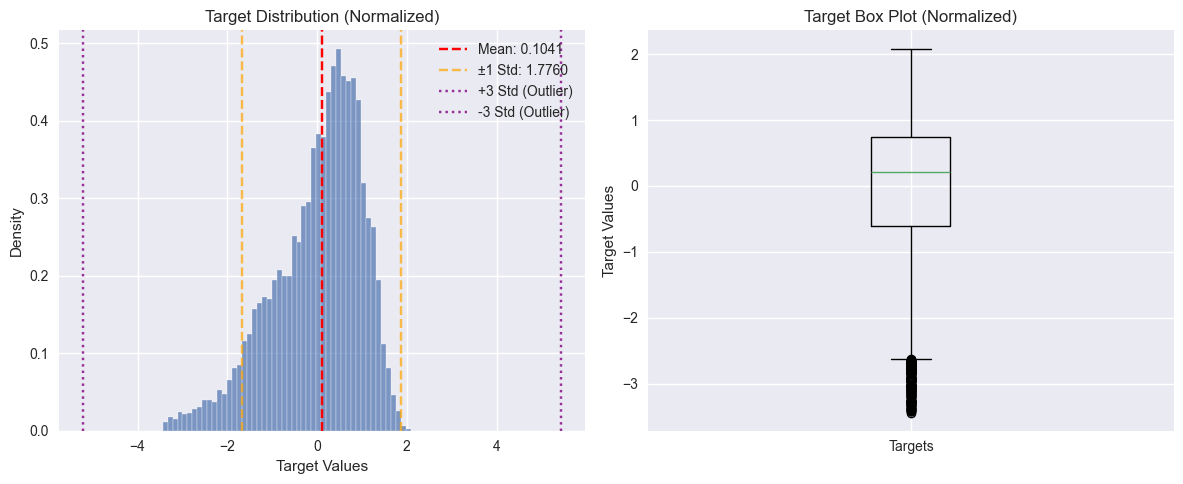

====== Filtering and Normalizing VAL ======


c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


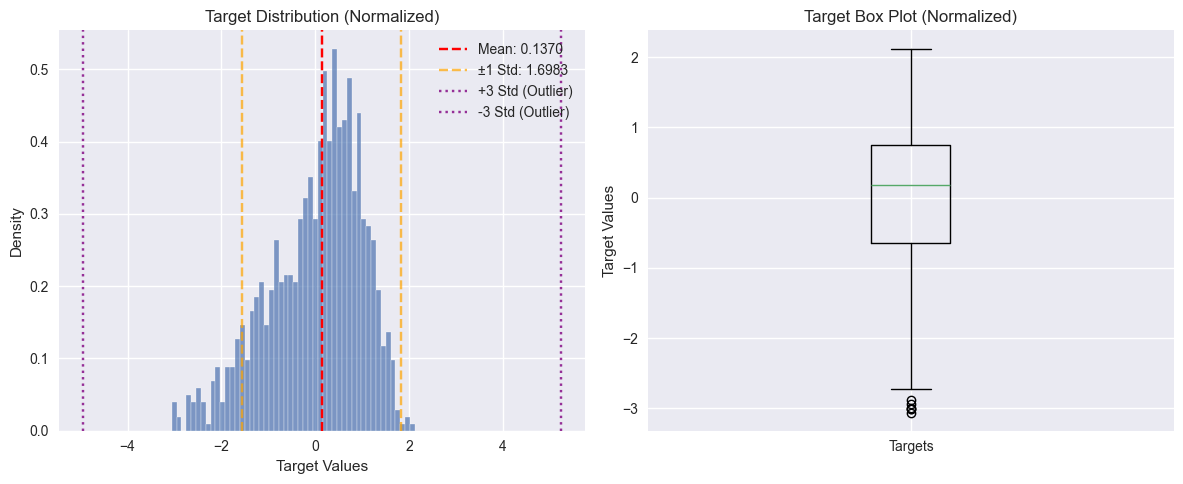

====== Filtering and Normalizing DONE ======

Dataset sizes after filtering:
Training: 9893 (was 10000)
Validation: 988 (was 1000)

Min and max of targets in normalized datasets:
Train: -3.4398, 2.0837
Val: -3.0586, 2.1231

Mean and std of targets in normalized datasets:
Train: -0.0000, 1.0000, original: 0.0153, 2.0109
Val: -0.0000, 1.0000, original: 0.0315, 1.9856

=== Testing normalization ===
Sample train target: 0.4115
Sample val target: 0.2903


c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `

(9893, 988)

In [9]:
from ACAgraphML.Pipeline import TargetNormalizer

# Create the normalizer and fit it to the training data
target_normalizer = TargetNormalizer(verbose=True)
target_normalizer.fit(train_dataset)

# Create filtered and normalized datasets
print('====== Filtering and Normalizing TRAIN ======')
normalized_train_dataset = target_normalizer.normalize(train_dataset)
print('====== Filtering and Normalizing VAL ======')
normalized_val_dataset = target_normalizer.normalize(val_dataset)
print('====== Filtering and Normalizing DONE ======')

print(f"\nDataset sizes after filtering:")
print(f"Training: {len(normalized_train_dataset)} (was {len(train_dataset)})")
print(f"Validation: {len(normalized_val_dataset)} (was {len(val_dataset)})")

# Print min and max of the targets in the normalized datasets
print(f"\nMin and max of targets in normalized datasets:")
print(f"Train: {torch.min(normalized_train_dataset.y):.4f}, {torch.max(normalized_train_dataset.y):.4f}")
print(f"Val: {torch.min(normalized_val_dataset.y):.4f}, {torch.max(normalized_val_dataset.y):.4f}")

print(f"\nMean and std of targets in normalized datasets:")
print(f"Train: {normalized_train_dataset.y.mean().item():.4f}, {normalized_train_dataset.y.std().item():.4f}, original: {train_dataset.data.y.mean().item():.4f}, {train_dataset.data.y.std().item():.4f}")
print(f"Val: {normalized_val_dataset.y.mean().item():.4f}, {normalized_val_dataset.y.std().item():.4f}, original: {val_dataset.data.y.mean().item():.4f}, {val_dataset.data.y.std().item():.4f}")

# Test that the normalization works
print(f"\n=== Testing normalization ===")
sample_train = normalized_train_dataset[0]
sample_val = normalized_val_dataset[0]
print(f"Sample train target: {sample_train.y.item():.4f}")
print(f"Sample val target: {sample_val.y.item():.4f}")

len(normalized_train_dataset), len(normalized_val_dataset)


## BON feature extraction

In [10]:
from ACAgraphML.Pipeline import DataAugmenter
# Use normalized datasets for all feature extraction and evaluation
print("Using normalized datasets for feature extraction...")

# Update dataset references to use normalized versions
train_dataset = normalized_train_dataset
val_dataset = normalized_val_dataset

# Extract normalized targets
y_train = train_dataset.y.numpy()
y_val = val_dataset.y.numpy()

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
print(f"Normalized target range: [{y_train.min():.4f}, {y_train.max():.4f}]")
print(f"Target stats - Train mean: {y_train.mean():.4f}, std: {y_train.std():.4f}")
print(f"Target stats - Val mean: {y_val.mean():.4f}, std: {y_val.std():.4f}")

# Extract BON Features (Bag of Nodes)
print("\nExtracting BON features...")
oneHotTransform = OneHotEncodeFeat(nClasses=NUM_NODE_FEATS)
train_bon = DataAugmenter(normalized_train_dataset, transforms=[oneHotTransform]).augment()
val_bon = DataAugmenter(normalized_val_dataset, transforms=[oneHotTransform]).augment()

# Sum node features for each graph (bag of nodes)
bon_train = torch.stack([g.x.sum(dim=0) for g in train_bon]).float()
bon_val = torch.stack([g.x.sum(dim=0) for g in val_bon]).float()

# Apply PCA to BON features
bon_train_mean = bon_train.mean(dim=0, keepdim=True)
bon_train_centered = bon_train - bon_train_mean
bon_val_centered = bon_val - bon_train_mean
U, S, V = torch.linalg.svd(bon_train_centered, full_matrices=False)
explained_variance = (S**2 / torch.sum(S**2)).numpy()

print(f"BON shape: {bon_train.shape}")
print(f"Top 5 explained variance: {explained_variance[:5]}")

# Transform to PCA space
bon_pca_train = bon_train_centered @ V.T
bon_pca_val = bon_val_centered @ V.T

# Store BON features (top 10 components based on correlation analysis)
for i in range(10):
    FEATURE_DICT[f'BON_PC{i+1}'] = {'train': bon_pca_train[:, i], 'val': bon_pca_val[:, i]}


print("BON features extracted successfully")

Using normalized datasets for feature extraction...
Train samples: 9893, Val samples: 988
Normalized target range: [-3.4398, 2.0837]
Target stats - Train mean: -0.0000, std: 0.9999
Target stats - Val mean: -0.0000, std: 0.9995

Extracting BON features...


Applying transforms:   0%|          | 0/9893 [00:00<?, ?it/s]

Applying transforms:   0%|          | 0/988 [00:00<?, ?it/s]

BON shape: torch.Size([9893, 28])
Top 5 explained variance: [0.7229314  0.1023901  0.0620902  0.03822845 0.02840336]
BON features extracted successfully


## BOE feature extraction

In [11]:
from ACAgraphML.Pipeline import DataAugmenter
# Extract BOE Features (Bag of Edges)
print("Extracting BOE features...")
oneHotEdgeTransform = OneHotEdgeFeats(nClasses=NUM_EDGE_FEATS)
train_boe = DataAugmenter(normalized_train_dataset, transforms=[oneHotEdgeTransform]).augment()
val_boe = DataAugmenter(normalized_val_dataset, transforms=[oneHotEdgeTransform]).augment()

# Sum edge features for each graph (bag of edges)
boe_train = torch.stack([g.edge_attr.sum(dim=0) for g in train_boe])
boe_val = torch.stack([g.edge_attr.sum(dim=0) for g in val_boe])

print(f"BOE shape: {boe_train.shape}")

# Find top 3 most correlated edge features with target
correlations = np.array([np.corrcoef(boe_train[:, i].numpy(), y_train)[0, 1] 
                        for i in range(boe_train.shape[1])])
correlations = np.nan_to_num(correlations)
top_boe_indices = np.argsort(np.abs(correlations))[-3:][::-1]

print(f"Top BOE feature correlations: {correlations[top_boe_indices]}")

# Store top BOE features
for i, idx in enumerate(top_boe_indices):
    FEATURE_DICT[f'BOE_{i+1}'] = {'train': boe_train[:, idx], 'val': boe_val[:, idx]}

print("BOE features extracted successfully")


Extracting BOE features...


Applying transforms:   0%|          | 0/9893 [00:00<?, ?it/s]

Applying transforms:   0%|          | 0/988 [00:00<?, ?it/s]

BOE shape: torch.Size([9893, 4])
Top BOE feature correlations: [0.56352522 0.0141707  0.00585929]
BOE features extracted successfully


c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## BOD feature extraction

In [12]:
# Extract BOD Features (Bag of Degrees)
print("Extracting BOD features...")
degreeTransform = T.OneHotDegree(max_degree=4)
train_bod = DataAugmenter(normalized_train_dataset, transforms=[degreeTransform]).augment()
val_bod = DataAugmenter(normalized_val_dataset, transforms=[degreeTransform]).augment()

# Extract degree features (last 4 columns after one-hot encoding)
bod_train = torch.stack([g.x[:, -4:].sum(dim=0) for g in train_bod])
bod_val = torch.stack([g.x[:, -4:].sum(dim=0) for g in val_bod])

print(f"BOD shape: {bod_train.shape}")

# Store all BOD features (degree 0, 1, 2, 3+)
for i in range(4):
    FEATURE_DICT[f'BOD_deg_{i}'] = {'train': bod_train[:, i], 'val': bod_val[:, i]}

print("BOD features extracted successfully")


Extracting BOD features...


Applying transforms:   0%|          | 0/9893 [00:00<?, ?it/s]

Applying transforms:   0%|          | 0/988 [00:00<?, ?it/s]

BOD shape: torch.Size([9893, 4])
BOD features extracted successfully


## Spectral feature extraction

In [13]:
# Extract Spectral Features (Laplacian Eigenvalues)
print("Extracting Spectral features...")
laplacianTransform = T.AddLaplacianEigenvectorPE(k=8, attr_name='laplacian_eigs')
train_spectral = DataAugmenter(normalized_train_dataset, transforms=[laplacianTransform]).augment()
val_spectral = DataAugmenter(normalized_val_dataset, transforms=[laplacianTransform]).augment()

# Extract the eigenvalues (taking the last row which corresponds to global graph features)
# Note: We're taking the eigenvalues themselves, not the eigenvectors
spectral_train = torch.stack([g.laplacian_eigs.sum(dim=0) for g in train_spectral])  # Sum over nodes
spectral_val = torch.stack([g.laplacian_eigs.sum(dim=0) for g in val_spectral])

print(f"Spectral shape: {spectral_train.shape}")

# Store all spectral features
for i in range(8):
    FEATURE_DICT[f'SPECTRAL_{i+1}'] = {'train': spectral_train[:, i], 'val': spectral_val[:, i]}

Extracting Spectral features...


Applying transforms:   0%|          | 0/9893 [00:00<?, ?it/s]

Applying transforms:   0%|          | 0/988 [00:00<?, ?it/s]

Spectral shape: torch.Size([9893, 8])


In [31]:
# Add a master node and compute its Random walk positional encodings
from ACAgraphML.Transforms import AddMasterNode
addMasterNodeTransform = AddMasterNode()
randomWalkPositionalEncoding = T.AddRandomWalkPE(walk_length=10, attr_name='rwpe')
transforms = [addMasterNodeTransform, randomWalkPositionalEncoding]
train_master = DataAugmenter(normalized_train_dataset, transforms=transforms).augment()
val_master = DataAugmenter(normalized_val_dataset, transforms=transforms).augment()

# Extract master node features (last node in each graph)
master_train = torch.stack([g.rwpe[-1, 1:] for g in train_master])
master_val = torch.stack([g.rwpe[-1, 1:] for g in val_master])
# Store master node features
for i in range(master_train.shape[1]):
    FEATURE_DICT[f'MASTER_RWPE_{i+1}'] = {'train': master_train[:, i], 'val': master_val[:, i]}
print("Spectral features extracted successfully")

Applying transforms:   0%|          | 0/9893 [00:00<?, ?it/s]

Applying transforms:   0%|          | 0/988 [00:00<?, ?it/s]

Spectral features extracted successfully


## Structural feature extraction

In [32]:
# Extract Structural Features 
print("Extracting Structural features...")

# Graph size features
num_nodes_train = torch.tensor([g.num_nodes for g in train_dataset], dtype=torch.float)
num_nodes_val = torch.tensor([g.num_nodes for g in val_dataset], dtype=torch.float)

num_edges_train = torch.tensor([g.edge_index.shape[1] for g in train_dataset], dtype=torch.float)
num_edges_val = torch.tensor([g.edge_index.shape[1] for g in val_dataset], dtype=torch.float)

# Graph density (edges / max_possible_edges)
density_train = num_edges_train / (num_nodes_train * (num_nodes_train - 1))
density_val = num_edges_val / (num_nodes_val * (num_nodes_val - 1))

# Handle isolated nodes (density = 0/0 = nan)
density_train = torch.nan_to_num(density_train, nan=0.0)
density_val = torch.nan_to_num(density_val, nan=0.0)

print(f"Graph size ranges:")
print(f"  Nodes: {num_nodes_train.min():.0f}-{num_nodes_train.max():.0f}")
print(f"  Edges: {num_edges_train.min():.0f}-{num_edges_train.max():.0f}")
print(f"  Density: {density_train.min():.4f}-{density_train.max():.4f}")

# Steady State Entropy
print("Computing steady state entropy...")
steadyStateTransform = SteadyStateTransform(useEdgeWeights=False)
train_ss = DataAugmenter(normalized_train_dataset, transforms=[steadyStateTransform]).augment()
val_ss = DataAugmenter(normalized_val_dataset, transforms=[steadyStateTransform]).augment()

def compute_entropy(steady_state):
    """Compute entropy of steady state distribution."""
    entropy = -torch.sum(steady_state * torch.log2(steady_state + 1e-10), dim=0)
    return entropy

ss_entropy_train = torch.stack([compute_entropy(g.x[:, 1]) for g in train_ss])
ss_entropy_val = torch.stack([compute_entropy(g.x[:, 1]) for g in val_ss])

print(f"Steady state entropy range: {ss_entropy_train.min():.4f}-{ss_entropy_train.max():.4f}")

# Store structural features
FEATURE_DICT['STRUCT_num_nodes'] = {'train': num_nodes_train, 'val': num_nodes_val}
FEATURE_DICT['STRUCT_num_edges'] = {'train': num_edges_train, 'val': num_edges_val}
FEATURE_DICT['STRUCT_density'] = {'train': density_train, 'val': density_val}
FEATURE_DICT['STRUCT_ss_entropy'] = {'train': ss_entropy_train, 'val': ss_entropy_val}

print("Structural features extracted successfully")
print(f"\nTotal features extracted: {len(FEATURE_DICT)}")

Extracting Structural features...
Graph size ranges:
  Nodes: 9-37
  Edges: 16-82
  Density: 0.0616-0.2222
Computing steady state entropy...


Applying transforms:   0%|          | 0/9893 [00:00<?, ?it/s]

Applying transforms:   0%|          | 0/988 [00:00<?, ?it/s]

Steady state entropy range: 1.8464-5.1372
Structural features extracted successfully

Total features extracted: 40


In [33]:
from sklearn.linear_model import Lasso
def LASSOfeatureSelection(features, target, features_val, target_val, alpha=0.1):
    """
    Perform LASSO feature selection and return the selected features.
    """
    lasso = Lasso(alpha=alpha)
    lasso.fit(features.numpy(), target.numpy())
    
    selected_features = np.where(lasso.coef_ != 0)[0]
    print(f"Selected Features: {selected_features}")

    y_pred = lasso.predict(features.numpy())
    y_val_pred = lasso.predict(features_val.numpy())

    #Evaluate the model
    mse = mean_squared_error(target_val.numpy(), y_val_pred)
    r2 = r2_score(target_val.numpy(), y_val_pred)
    mae = mean_absolute_error(target_val.numpy(), y_val_pred)
    print(f"LASSO Mean Squared Error: {mse}")
    print(f"LASSO R^2 Score: {r2}")
    print(f"LASSO Mean Absolute Error: {mae}")
    plotTrueVsPred(target.numpy(), y_pred, target_val.numpy(), y_val_pred, title='LASSO: True vs Predicted Values')

    #Plot the coefficients
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(lasso.coef_)), lasso.coef_, color='skyblue')
    plt.title('LASSO Coefficients')
    plt.xlabel('Feature Index')
    plt.ylabel('Coefficient Value')
    plt.axhline(0, color='red', linestyle='--')
    plt.xticks(range(0, len(lasso.coef_)))
    plt.grid(axis='y')
    plt.show()
    
    return selected_features, lasso.coef_

# 3. Feature Evaluation

Now we'll systematically evaluate each feature group using all regressors to understand their individual contributions to prediction performance.

In [34]:
# Create consolidated feature dataset from FEATURE_DICT
import pandas as pd

# Convert FEATURE_DICT to a proper DataFrame format for easier analysis
feature_data = {'train': {}, 'val': {}}

for feature_name, data in FEATURE_DICT.items():
    feature_data['train'][feature_name] = data['train'].numpy() if hasattr(data['train'], 'numpy') else data['train']
    feature_data['val'][feature_name] = data['val'].numpy() if hasattr(data['val'], 'numpy') else data['val']

# Create DataFrames
train_features_df = pd.DataFrame(feature_data['train'])
val_features_df = pd.DataFrame(feature_data['val'])

print(f"Training features shape: {train_features_df.shape}")
print(f"Validation features shape: {val_features_df.shape}")
print(f"Available features: {list(train_features_df.columns)}")

# Group features for evaluation based on available features in FEATURE_DICT
available_features = list(FEATURE_DICT.keys())

FEATURE_GROUPS = {
    'BON': [f for f in available_features if f.startswith('BON_PC')],
    'BOE': [f for f in available_features if f.startswith('BOE_')],
    'BOD': [f for f in available_features if f.startswith('BOD_')],
    'Spectral': [f for f in available_features if f.startswith('SPECTRAL_')],
    'Structural': [f for f in available_features if f.startswith('STRUCT_')],
    'MasterNode': [f for f in available_features if f.startswith('MASTER_RWPE_')],
}

print("\nFeature Groups:")
for group_name, features in FEATURE_GROUPS.items():
    print(f"  {group_name}: {len(features)} features")
    print(f"    {features}")
    print()

Training features shape: (9893, 40)
Validation features shape: (988, 40)
Available features: ['BON_PC1', 'BON_PC2', 'BON_PC3', 'BON_PC4', 'BON_PC5', 'BON_PC6', 'BON_PC7', 'BON_PC8', 'BON_PC9', 'BON_PC10', 'BOE_1', 'BOE_2', 'BOE_3', 'BOD_deg_0', 'BOD_deg_1', 'BOD_deg_2', 'BOD_deg_3', 'SPECTRAL_1', 'SPECTRAL_2', 'SPECTRAL_3', 'SPECTRAL_4', 'SPECTRAL_5', 'SPECTRAL_6', 'SPECTRAL_7', 'SPECTRAL_8', 'MASTER_RWPE_1', 'MASTER_RWPE_2', 'MASTER_RWPE_3', 'MASTER_RWPE_4', 'MASTER_RWPE_5', 'MASTER_RWPE_6', 'MASTER_RWPE_7', 'MASTER_RWPE_8', 'MASTER_RWPE_9', 'MASTER_RWPE_10', 'MASTER_RWPE_11', 'STRUCT_num_nodes', 'STRUCT_num_edges', 'STRUCT_density', 'STRUCT_ss_entropy']

Feature Groups:
  BON: 10 features
    ['BON_PC1', 'BON_PC2', 'BON_PC3', 'BON_PC4', 'BON_PC5', 'BON_PC6', 'BON_PC7', 'BON_PC8', 'BON_PC9', 'BON_PC10']

  BOE: 3 features
    ['BOE_1', 'BOE_2', 'BOE_3']

  BOD: 4 features
    ['BOD_deg_0', 'BOD_deg_1', 'BOD_deg_2', 'BOD_deg_3']

  Spectral: 8 features
    ['SPECTRAL_1', 'SPECTRAL_2', 

In [35]:
# Evaluate each feature group
group_results = {}

for group_name, feature_list in FEATURE_GROUPS.items():
    if not feature_list:  # Skip empty groups
        print(f"\nSkipping {group_name} - no features available")
        continue
        
    print(f"\nEvaluating {group_name} features...")
    
    # Get features for this group from training data
    X_train_group = train_features_df[feature_list].values
    X_val_group = val_features_df[feature_list].values
    
    # Evaluate with all regressors
    results = evaluate_regressors(X_train_group, y_train, X_val_group, y_val, 
                                 feature_name=f"{group_name} Group", verbose=True)
    group_results[group_name] = results
    
    # Print summary
    print(f"  Best model: {results['best_model']} (MAE: {results['best_mae']:.4f})")

# Store results for plotting
GROUP_EVALUATION_RESULTS = group_results


Evaluating BON features...

BON Group Results:
  Features: 10
  LASSO: 0.6130
  RF: 0.4170
  XGB: 0.3662
  SVR: 0.3974
  Best: XGB (0.3662)
  Best model: XGB (MAE: 0.3662)

Evaluating BOE features...

BOE Group Results:
  Features: 3
  LASSO: 0.6472
  RF: 0.6345
  XGB: 0.6234
  SVR: 0.6211
  Best: SVR (0.6211)
  Best model: SVR (MAE: 0.6211)

Evaluating BOD features...

BOD Group Results:
  Features: 4
  LASSO: 0.7773
  RF: 0.7693
  XGB: 0.7474
  SVR: 0.7419
  Best: SVR (0.7419)
  Best model: SVR (MAE: 0.7419)

Evaluating Spectral features...

Spectral Group Results:
  Features: 8
  LASSO: 0.8071
  RF: 0.7897
  XGB: 0.7980
  SVR: 0.7853
  Best: SVR (0.7853)
  Best model: SVR (MAE: 0.7853)

Evaluating Structural features...

Structural Group Results:
  Features: 4
  LASSO: 0.7787
  RF: 0.8789
  XGB: 0.7479
  SVR: 0.7456
  Best: SVR (0.7456)
  Best model: SVR (MAE: 0.7456)

Evaluating MasterNode features...

MasterNode Group Results:
  Features: 11
  LASSO: 0.8071
  RF: 0.7999
  XGB: 0.

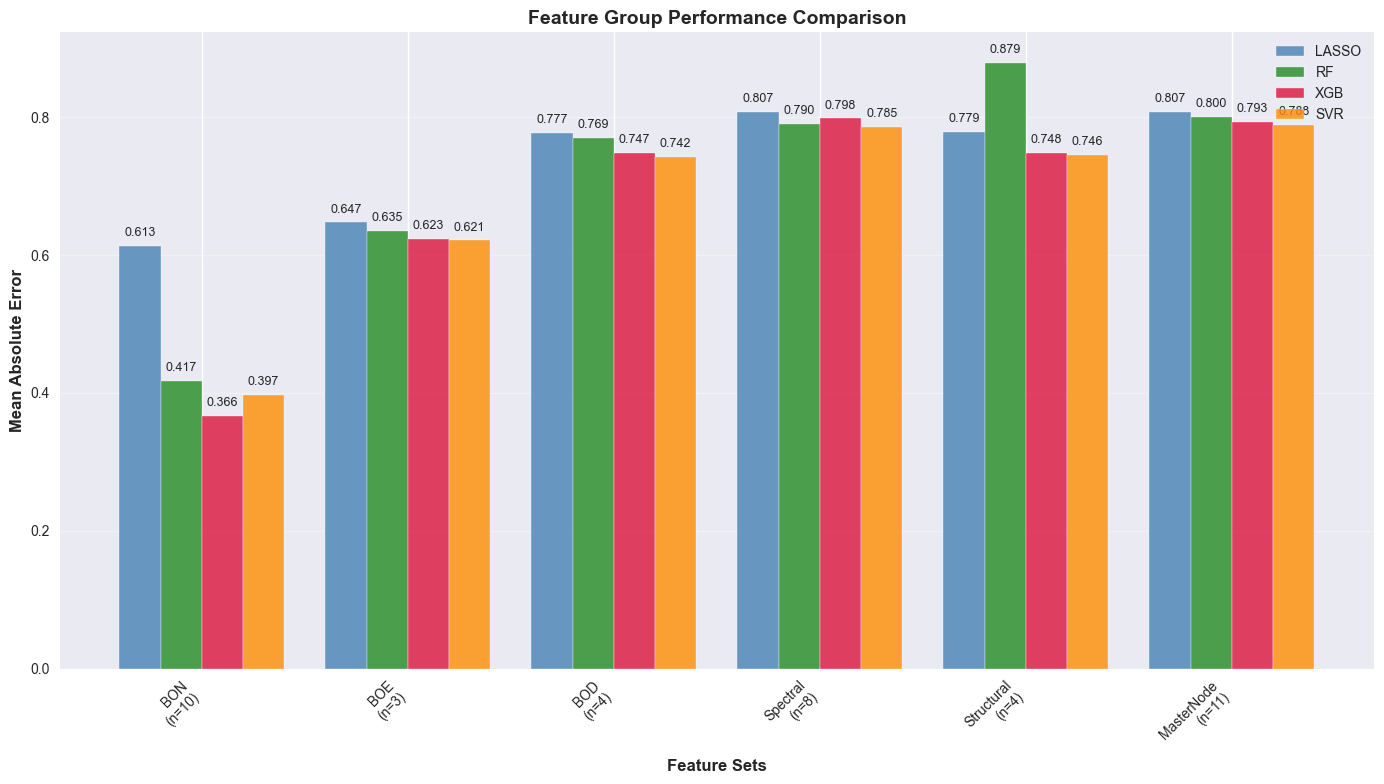


Feature Group Performance Summary:
     Group Best_Model  Best_MAE  LASSO_MAE  RF_MAE  XGB_MAE  SVR_MAE  Features
       BON        XGB    0.3662     0.6130  0.4170   0.3662   0.3974        10
       BOE        SVR    0.6211     0.6472  0.6345   0.6234   0.6211         3
       BOD        SVR    0.7419     0.7773  0.7693   0.7474   0.7419         4
Structural        SVR    0.7456     0.7787  0.8789   0.7479   0.7456         4
  Spectral        SVR    0.7853     0.8071  0.7897   0.7980   0.7853         8
MasterNode        SVR    0.7884     0.8071  0.7999   0.7926   0.7884        11


In [36]:
# Visualize feature group evaluation results
plot_evaluation_comparison(GROUP_EVALUATION_RESULTS, title="Feature Group Performance Comparison")

# Print summary table
print("\nFeature Group Performance Summary:")
summary_data = []
for group_name, results in GROUP_EVALUATION_RESULTS.items():
    summary_data.append({
        'Group': group_name,
        'Best_Model': results['best_model'],
        'Best_MAE': results['best_mae'],
        'LASSO_MAE': results.get('LASSO', 'N/A'),
        'RF_MAE': results.get('RF', 'N/A'),
        'XGB_MAE': results.get('XGB', 'N/A'),
        'SVR_MAE': results.get('SVR', 'N/A'),
        'Features': results['n_features']
    })

summary_df = pd.DataFrame(summary_data).sort_values('Best_MAE')
print(summary_df.to_string(index=False, float_format='%.4f'))

In [37]:
print(FEATURE_GROUPS)

{'BON': ['BON_PC1', 'BON_PC2', 'BON_PC3', 'BON_PC4', 'BON_PC5', 'BON_PC6', 'BON_PC7', 'BON_PC8', 'BON_PC9', 'BON_PC10'], 'BOE': ['BOE_1', 'BOE_2', 'BOE_3'], 'BOD': ['BOD_deg_0', 'BOD_deg_1', 'BOD_deg_2', 'BOD_deg_3'], 'Spectral': ['SPECTRAL_1', 'SPECTRAL_2', 'SPECTRAL_3', 'SPECTRAL_4', 'SPECTRAL_5', 'SPECTRAL_6', 'SPECTRAL_7', 'SPECTRAL_8'], 'Structural': ['STRUCT_num_nodes', 'STRUCT_num_edges', 'STRUCT_density', 'STRUCT_ss_entropy'], 'MasterNode': ['MASTER_RWPE_1', 'MASTER_RWPE_2', 'MASTER_RWPE_3', 'MASTER_RWPE_4', 'MASTER_RWPE_5', 'MASTER_RWPE_6', 'MASTER_RWPE_7', 'MASTER_RWPE_8', 'MASTER_RWPE_9', 'MASTER_RWPE_10', 'MASTER_RWPE_11']}


Correlation Analysis: Feature Groups vs Target
Correlation Analysis: Feature Groups vs Target

Analyzing group: BON with 10 features
  Feature: BON_PC1, Correlation with target: -0.3826, feature values: [-4.938309  -2.9047375  4.3217974 -2.816291  -2.407909 ]...
  Feature: BON_PC2, Correlation with target: -0.0350, feature values: [ 0.50284725 -1.333619   -0.42593184 -3.0603275   1.8159146 ]...
  Feature: BON_PC3, Correlation with target: 0.0727, feature values: [ 1.3584806   0.01775873 -0.68449646 -1.2455208  -2.443778  ]...
  Feature: BON_PC4, Correlation with target: -0.3420, feature values: [-0.55199176 -0.34152687 -0.9892738  -0.3679761  -0.9842165 ]...
  Feature: BON_PC5, Correlation with target: -0.0744, feature values: [0.25809202 0.29181656 0.5565496  0.530818   0.70414233]...
  Feature: BON_PC6, Correlation with target: 0.1113, feature values: [ 0.44271076 -0.5448716  -0.5761534   0.5045823  -0.35771227]...
  Feature: BON_PC7, Correlation with target: -0.2371, feature values:

c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Polimi\Master\2Sem\ACA_GraphML_Project\.conda\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Paolo\AppData\Local\Temp\ipykernel_8116\984221968.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df, x='Group', y='Mean_Abs_Correlation', palette='viridis')
C:\Users\Paolo\AppData\Local\Temp\ipykernel_8116\984221968.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=corr_df, x='Group', y='Max_Abs_Correl

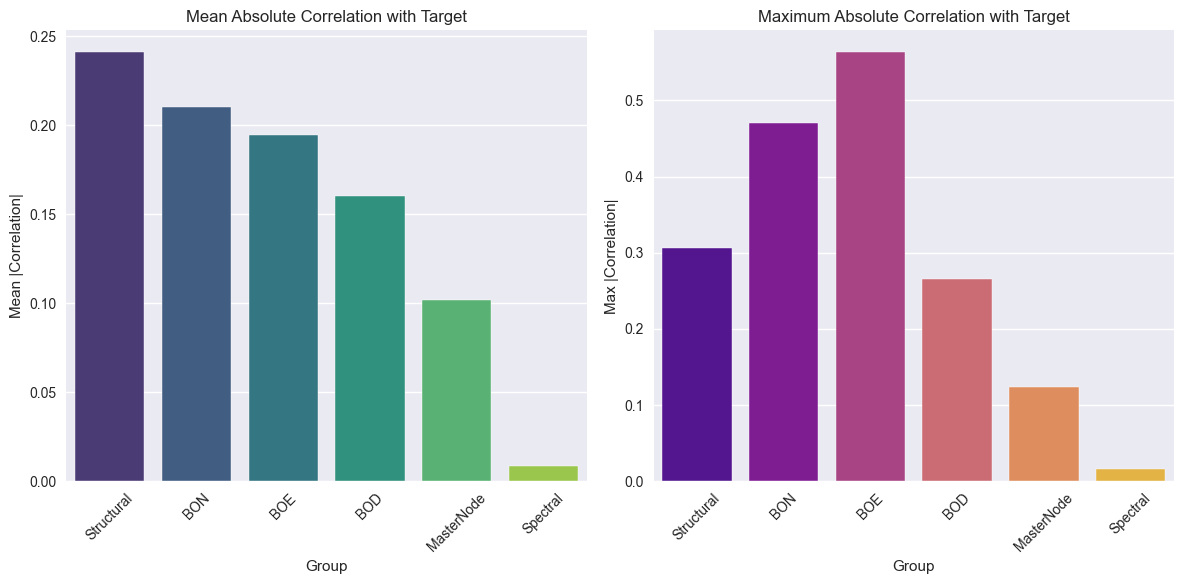

In [ ]:
# Correlation analysis between feature groups and target
print("Correlation Analysis: Feature Groups vs Target")
print("=" * 50)

# Correlation analysis between feature groups and target
print("Correlation Analysis: Feature Groups vs Target")
print("=" * 50)

correlation_data = []
for group_name, feature_list in FEATURE_GROUPS.items():
    if not feature_list:  # Skip empty groups
        continue
        
    # Calculate mean correlation for features in the group
    correlations = []
    
    for feature in feature_list:
        feature_values = train_features_df[feature].values
        corr = np.corrcoef(feature_values, y_train)[0, 1]
        if not np.isnan(corr):
            correlations.append(abs(corr))
    print(correlations)
    if correlations:
        mean_corr = np.mean(correlations)
        max_corr = np.max(correlations)
        correlation_data.append({
            'Group': group_name,
            'Mean_Abs_Correlation': mean_corr,
            'Max_Abs_Correlation': max_corr,
            'Num_Features': len(feature_list)
        })

# Create correlation DataFrame
corr_df = pd.DataFrame(correlation_data).sort_values('Mean_Abs_Correlation', ascending=False)
print(corr_df.to_string(index=False, float_format='%.4f'))

# Plot correlation comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=corr_df, x='Group', y='Mean_Abs_Correlation', palette='viridis')
plt.title('Mean Absolute Correlation with Target')
plt.xticks(rotation=45)
plt.ylabel('Mean |Correlation|')

plt.subplot(1, 2, 2)
sns.barplot(data=corr_df, x='Group', y='Max_Abs_Correlation', palette='plasma')
plt.title('Maximum Absolute Correlation with Target')
plt.xticks(rotation=45)
plt.ylabel('Max |Correlation|')

plt.tight_layout()
plt.show()

# 4. Wrapper Method: Forward Feature Selection

We'll use a two-pass forward feature selection approach:
1. **Pass 1**: Select the best feature groups in order
2. **Pass 2**: Select the best individual features from the selected groups

In [39]:
# Pass 1: Forward Selection on Feature Groups
print("Pass 1: Forward Selection on Feature Groups")
print("=" * 50)

# Prepare group features as candidates - convert to dict format for forward_feature_selection
group_candidates = {}
for group_name, feature_list in FEATURE_GROUPS.items():
    if feature_list:  # Only include non-empty groups
        # Combine all features in the group
        group_data = train_features_df[feature_list].values
        group_candidates[group_name] = {'train': group_data, 'val': val_features_df[feature_list].values}

# Perform forward selection on groups using the existing forward_feature_selection function
selected_groups_results = forward_feature_selection(
    feature_dict=group_candidates,
    y_train=y_train,
    y_val=y_val,
    max_features=len(group_candidates),
    verbose=True
)

selected_groups = selected_groups_results['selected_features']
group_selection_history = selected_groups_results['selection_history']

print(f"\nSelected feature groups (in order): {selected_groups}")

# Combine selected group features
selected_group_features = []
for group_name in selected_groups:
    selected_group_features.extend(FEATURE_GROUPS[group_name])

print(f"\nTotal features from selected groups: {len(selected_group_features)}")
print(f"Selected features: {selected_group_features}")

Pass 1: Forward Selection on Feature Groups
Forward Feature Selection
Baseline MAE (mean prediction): 0.8071
Available features: ['BON', 'BOE', 'BOD', 'Spectral', 'Structural', 'MasterNode']
------------------------------------------------------------
Step 1: Added 'BON' | MAE: 0.3611 | Improvement: 0.4460
Step 2: Added 'BOE' | MAE: 0.3373 | Improvement: 0.0238
Step 3: Added 'BOD' | MAE: 0.3273 | Improvement: 0.0101
Step 4: Added 'MasterNode' | MAE: 0.3175 | Improvement: 0.0098
Step 5: No improvement found. Stopping.
------------------------------------------------------------
Final selection: ['BON', 'BOE', 'BOD', 'MasterNode']
Final MAE: 0.3175
Total improvement: 0.4896

Selected feature groups (in order): ['BON', 'BOE', 'BOD', 'MasterNode']

Total features from selected groups: 28
Selected features: ['BON_PC1', 'BON_PC2', 'BON_PC3', 'BON_PC4', 'BON_PC5', 'BON_PC6', 'BON_PC7', 'BON_PC8', 'BON_PC9', 'BON_PC10', 'BOE_1', 'BOE_2', 'BOE_3', 'BOD_deg_0', 'BOD_deg_1', 'BOD_deg_2', 'BOD_deg

In [40]:
# Pass 2: Forward Selection on Individual Features
print("\nPass 2: Forward Selection on Individual Features")
print("=" * 50)

# Prepare individual features from selected groups as candidates
individual_candidates = {}
for feature_name in selected_group_features:
    individual_candidates[feature_name] = {
        'train': train_features_df[feature_name].values, 
        'val': val_features_df[feature_name].values
    }

# Perform forward selection on individual features
selected_features_results = forward_feature_selection(
    feature_dict=individual_candidates,
    y_train=y_train,
    y_val=y_val,
    max_features=min(20, len(selected_group_features)),  # Limit to 20 features max
    verbose=True
)

selected_features = selected_features_results['selected_features']
feature_selection_history = selected_features_results['selection_history']

print(f"\nFinal selected features (in order): {selected_features}")
print(f"Total selected features: {len(selected_features)}")

# Print detailed selection history
print(f"\nFeature selection history:")
for i, step_info in enumerate(feature_selection_history, 1):
    feature_name = step_info['feature']
    mae = step_info['mae']
    improvement = step_info['improvement']
    
    # Find which group this feature belongs to
    feature_group = None
    for group_name, group_features in FEATURE_GROUPS.items():
        if feature_name in group_features:
            feature_group = group_name
            break
    print(f"  {i:2d}. {feature_name:20s} (MAE: {mae:.4f}, Improvement: {improvement:.4f}) [{feature_group}]")


Pass 2: Forward Selection on Individual Features
Forward Feature Selection
Baseline MAE (mean prediction): 0.8071
Available features: ['BON_PC1', 'BON_PC2', 'BON_PC3', 'BON_PC4', 'BON_PC5', 'BON_PC6', 'BON_PC7', 'BON_PC8', 'BON_PC9', 'BON_PC10', 'BOE_1', 'BOE_2', 'BOE_3', 'BOD_deg_0', 'BOD_deg_1', 'BOD_deg_2', 'BOD_deg_3', 'MASTER_RWPE_1', 'MASTER_RWPE_2', 'MASTER_RWPE_3', 'MASTER_RWPE_4', 'MASTER_RWPE_5', 'MASTER_RWPE_6', 'MASTER_RWPE_7', 'MASTER_RWPE_8', 'MASTER_RWPE_9', 'MASTER_RWPE_10', 'MASTER_RWPE_11']
------------------------------------------------------------
Step 1: Added 'BON_PC8' | MAE: 0.6114 | Improvement: 0.1956
Step 2: Added 'BOE_1' | MAE: 0.5200 | Improvement: 0.0914
Step 3: Added 'BON_PC5' | MAE: 0.4548 | Improvement: 0.0653
Step 4: Added 'BON_PC9' | MAE: 0.4132 | Improvement: 0.0416
Step 5: Added 'BON_PC10' | MAE: 0.3796 | Improvement: 0.0336
Step 6: Added 'BON_PC1' | MAE: 0.3654 | Improvement: 0.0142
Step 7: Added 'BON_PC4' | MAE: 0.3460 | Improvement: 0.0194
Step 

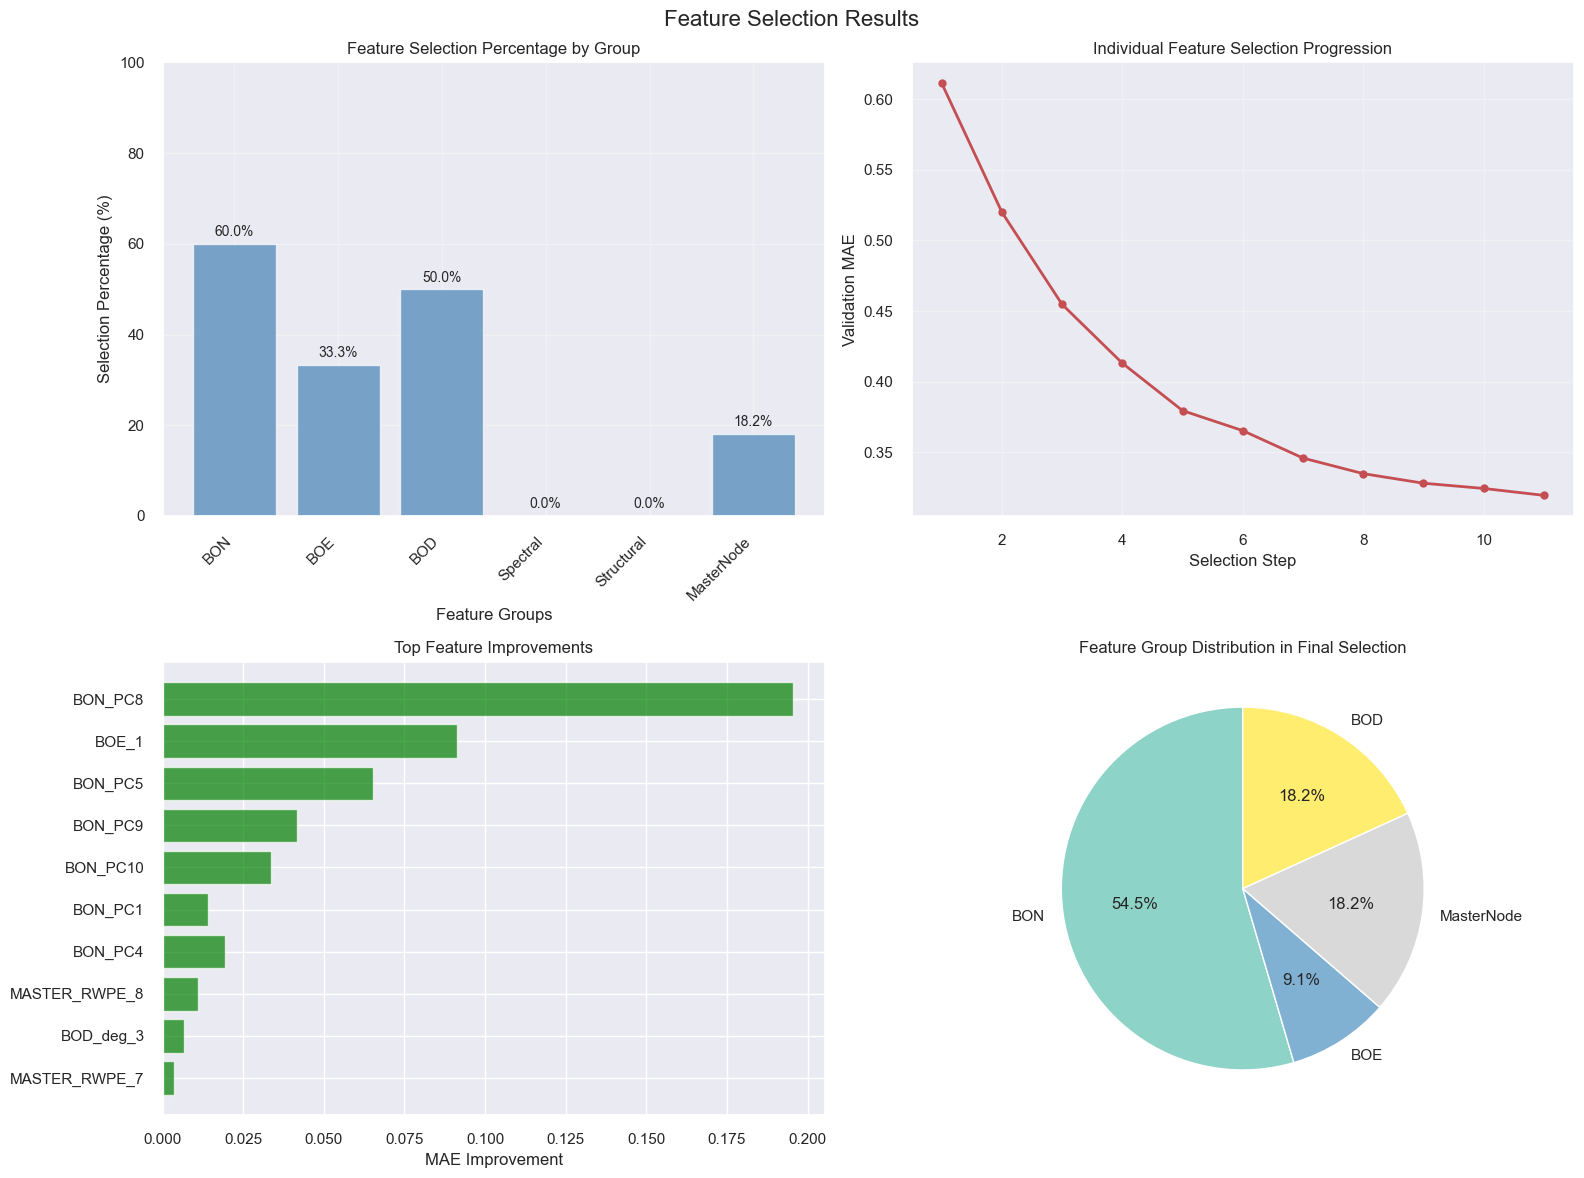

In [46]:
# Visualize Feature Selection Results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Selection Results', fontsize=16, y=0.98)

# 1. Feature group selection percentage
group_selection_pct = {}
for group_name, group_features in FEATURE_GROUPS.items():
    if group_features:  # Only process non-empty groups
        selected_count = sum(1 for feature in selected_features if feature in group_features)
        total_count = len(group_features)
        group_selection_pct[group_name] = (selected_count / total_count) * 100

if group_selection_pct:
    groups, percentages = zip(*group_selection_pct.items())
    bars = axes[0, 0].bar(range(len(groups)), percentages, color='steelblue', alpha=0.7)
    axes[0, 0].set_title('Feature Selection Percentage by Group')
    axes[0, 0].set_xlabel('Feature Groups')
    axes[0, 0].set_ylabel('Selection Percentage (%)')
    axes[0, 0].set_xticks(range(len(groups)))
    axes[0, 0].set_xticklabels(groups, rotation=45, ha='right')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, 100)
    
    # Add percentage labels on bars
    for bar, pct in zip(bars, percentages):
        axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                       f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)

# 2. Individual feature selection progression
if feature_selection_history:
    mae_progression = [step['mae'] for step in feature_selection_history]
    axes[0, 1].plot(range(1, len(mae_progression) + 1), mae_progression, 'ro-', linewidth=2, markersize=6)
    axes[0, 1].set_title('Individual Feature Selection Progression')
    axes[0, 1].set_xlabel('Selection Step')
    axes[0, 1].set_ylabel('Validation MAE')
    axes[0, 1].grid(True, alpha=0.3)

# 3. Feature improvement ranking (top 10)
if feature_selection_history:
    top_features = feature_selection_history[:min(10, len(feature_selection_history))]
    feature_names = [step['feature'] for step in top_features]
    improvements = [step['improvement'] for step in top_features]
    
    y_pos = np.arange(len(feature_names))
    bars = axes[1, 0].barh(y_pos, improvements, color='green', alpha=0.7)
    axes[1, 0].set_yticks(y_pos)
    axes[1, 0].set_yticklabels([name[:15] + '...' if len(name) > 15 else name for name in feature_names])
    axes[1, 0].set_xlabel('MAE Improvement')
    axes[1, 0].set_title('Top Feature Improvements')
    axes[1, 0].invert_yaxis()

# 4. Feature group distribution in final selection
group_counts = {}
for feature in selected_features:
    for group_name, group_features in FEATURE_GROUPS.items():
        if feature in group_features:
            group_counts[group_name] = group_counts.get(group_name, 0) + 1
            break

if group_counts:
    groups, counts = zip(*group_counts.items())
    colors = plt.cm.Set3(np.linspace(0, 1, len(groups)))
    wedges, texts, autotexts = axes[1, 1].pie(counts, labels=groups, autopct='%1.1f%%', 
                                             colors=colors, startangle=90)
    axes[1, 1].set_title('Feature Group Distribution in Final Selection')

plt.tight_layout()
plt.show()

# 5. Final Model Evaluation

In [42]:
# Final Model Evaluation
print("Final Model Evaluation")
print("=" * 50)

# Evaluate final selected features with all regressors
X_final_train = train_features_df[selected_features].values
X_final_val = val_features_df[selected_features].values
final_results = evaluate_regressors(X_final_train, y_train, X_final_val, y_val, 
                                   feature_name="Final Selected Features", verbose=True)

# Compare with baseline (all features)
X_all_train = train_features_df.values
X_all_val = val_features_df.values
baseline_results = evaluate_regressors(X_all_train, y_train, X_all_val, y_val, 
                                      feature_name="All Features", verbose=True)

# Print comparison
print(f"\nFeature Reduction Summary:")
print(f"  Original features: {len(train_features_df.columns)}")
print(f"  Selected features: {len(selected_features)}")
print(f"  Reduction: {(1 - len(selected_features)/len(train_features_df.columns))*100:.1f}%")

print(f"\nPerformance Comparison:")
print(f"{'Regressor':<15} {'Baseline MAE':<12} {'Selected MAE':<12} {'Improvement':<12}")
print("-" * 55)

for regressor in ['LASSO', 'RF', 'XGB', 'SVR']:
    baseline_mae = baseline_results[regressor]
    selected_mae = final_results[regressor]
    improvement = ((baseline_mae - selected_mae) / baseline_mae) * 100
    print(f"{regressor:<15} {baseline_mae:<12.4f} {selected_mae:<12.4f} {improvement:<12.2f}%")

print(f"\nBest Final Model: {final_results['best_model']}")
print(f"  MAE: {final_results['best_mae']:.4f}")
print(f"  Feature count: {final_results['n_features']}")

# Create final feature importance summary
print(f"\nFinal Selected Features (ranked by selection order):")
for i, feature in enumerate(selected_features, 1):
    # Find group
    feature_group = None
    for group_name, group_features in FEATURE_GROUPS.items():
        if feature in group_features:
            feature_group = group_name
            break
    print(f"  {i:2d}. {feature:25s} [{feature_group}]")

Final Model Evaluation

Final Selected Features Results:
  Features: 11
  LASSO: 0.5854
  RF: 0.3769
  XGB: 0.3203
  SVR: 0.4107
  Best: XGB (0.3203)

All Features Results:
  Features: 40
  LASSO: 0.5919
  RF: 0.3627
  XGB: 0.3224
  SVR: 0.4567
  Best: XGB (0.3224)

Feature Reduction Summary:
  Original features: 40
  Selected features: 11
  Reduction: 72.5%

Performance Comparison:
Regressor       Baseline MAE Selected MAE Improvement 
-------------------------------------------------------
LASSO           0.5919       0.5854       1.11        %
RF              0.3627       0.3769       -3.91       %
XGB             0.3224       0.3203       0.65        %
SVR             0.4567       0.4107       10.07       %

Best Final Model: XGB
  MAE: 0.3203
  Feature count: 11

Final Selected Features (ranked by selection order):
   1. BON_PC8                   [BON]
   2. BOE_1                     [BOE]
   3. BON_PC5                   [BON]
   4. BON_PC9                   [BON]
   5. BON_PC10  

Final Model Evaluation with Visualization
Best performing model: XGB
Best MAE on selected features: 0.3203

Detailed Performance Metrics:
Training   - R²: 0.8332, RMSE: 0.4084
Validation - R²: 0.7629, RMSE: 0.4867


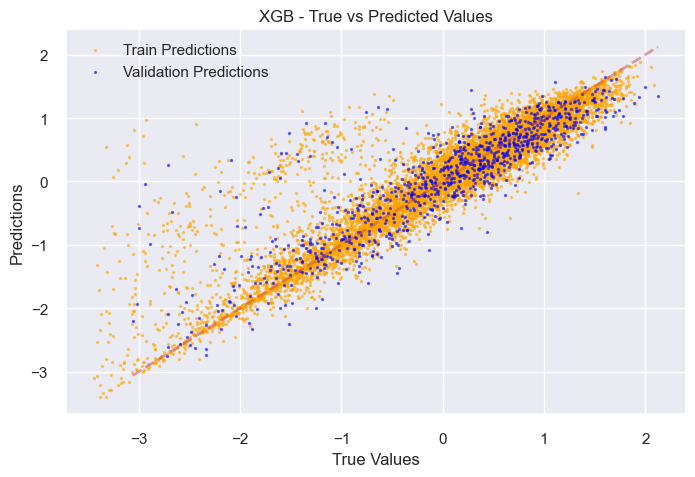

<Figure size 800x550 with 0 Axes>


Selected Features Summary:
Total features selected: 11 out of 40
Feature reduction: 72.5%

Selected features by group:
  BON: 6 features - ['BON_PC8', 'BON_PC5', 'BON_PC9', 'BON_PC10', 'BON_PC1', 'BON_PC4']
  BOE: 1 features - ['BOE_1']
  BOD: 2 features - ['BOD_deg_3', 'BOD_deg_2']
  MasterNode: 2 features - ['MASTER_RWPE_8', 'MASTER_RWPE_7']


In [43]:
# Final Model Evaluation with True vs Predicted Plot
print("Final Model Evaluation with Visualization")
print("=" * 60)

# Get the best regressor from final results
best_regressor_name = final_results['best_model']
best_mae = final_results['best_mae']

print(f"Best performing model: {best_regressor_name}")
print(f"Best MAE on selected features: {best_mae:.4f}")

# Train the best regressor on final selected features to get predictions
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor  
from sklearn.svm import SVR
from xgboost import XGBRegressor
from ACAgraphML.utils import plotTrueVsPred

# Map regressor names to actual models
regressors = {
    'LASSO': Lasso(alpha=0.1, random_state=42),
    'RF': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGB': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, 
                       objective="reg:absoluteerror", verbosity=0),
    'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1)
}

# Train the best model
best_model = regressors[best_regressor_name]
best_model.fit(X_final_train, y_train)

# Get predictions
y_train_pred = best_model.predict(X_final_train)
y_val_pred = best_model.predict(X_final_val)

# Calculate additional metrics
from sklearn.metrics import r2_score, mean_squared_error
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"\nDetailed Performance Metrics:")
print(f"Training   - R²: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
print(f"Validation - R²: {val_r2:.4f}, RMSE: {val_rmse:.4f}")

plotTrueVsPred(y_train, y_train_pred, y_val, y_val_pred, title=f'{best_regressor_name} - True vs Predicted Values', hardLimit=False)

plt.suptitle(f'Best Model Performance: {best_regressor_name} on Selected Features\nMAE = {best_mae:.4f}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance summary
print(f"\nSelected Features Summary:")
print(f"Total features selected: {len(selected_features)} out of {len(train_features_df.columns)}")
print(f"Feature reduction: {(1 - len(selected_features)/len(train_features_df.columns))*100:.1f}%")
print(f"\nSelected features by group:")
for group_name in FEATURE_GROUPS.keys():
    group_features_selected = [f for f in selected_features if f in FEATURE_GROUPS[group_name]]
    if group_features_selected:
        print(f"  {group_name}: {len(group_features_selected)} features - {group_features_selected}")


t-SNE Visualization of Selected Features
Combined features shape: (10881, 11)
Selected features: ['BON_PC8', 'BOE_1', 'BON_PC5', 'BON_PC9', 'BON_PC10', 'BON_PC1', 'BON_PC4', 'MASTER_RWPE_8', 'BOD_deg_3', 'MASTER_RWPE_7', 'BOD_deg_2']
Applying t-SNE...
t-SNE completed. Shape: (10881, 2)


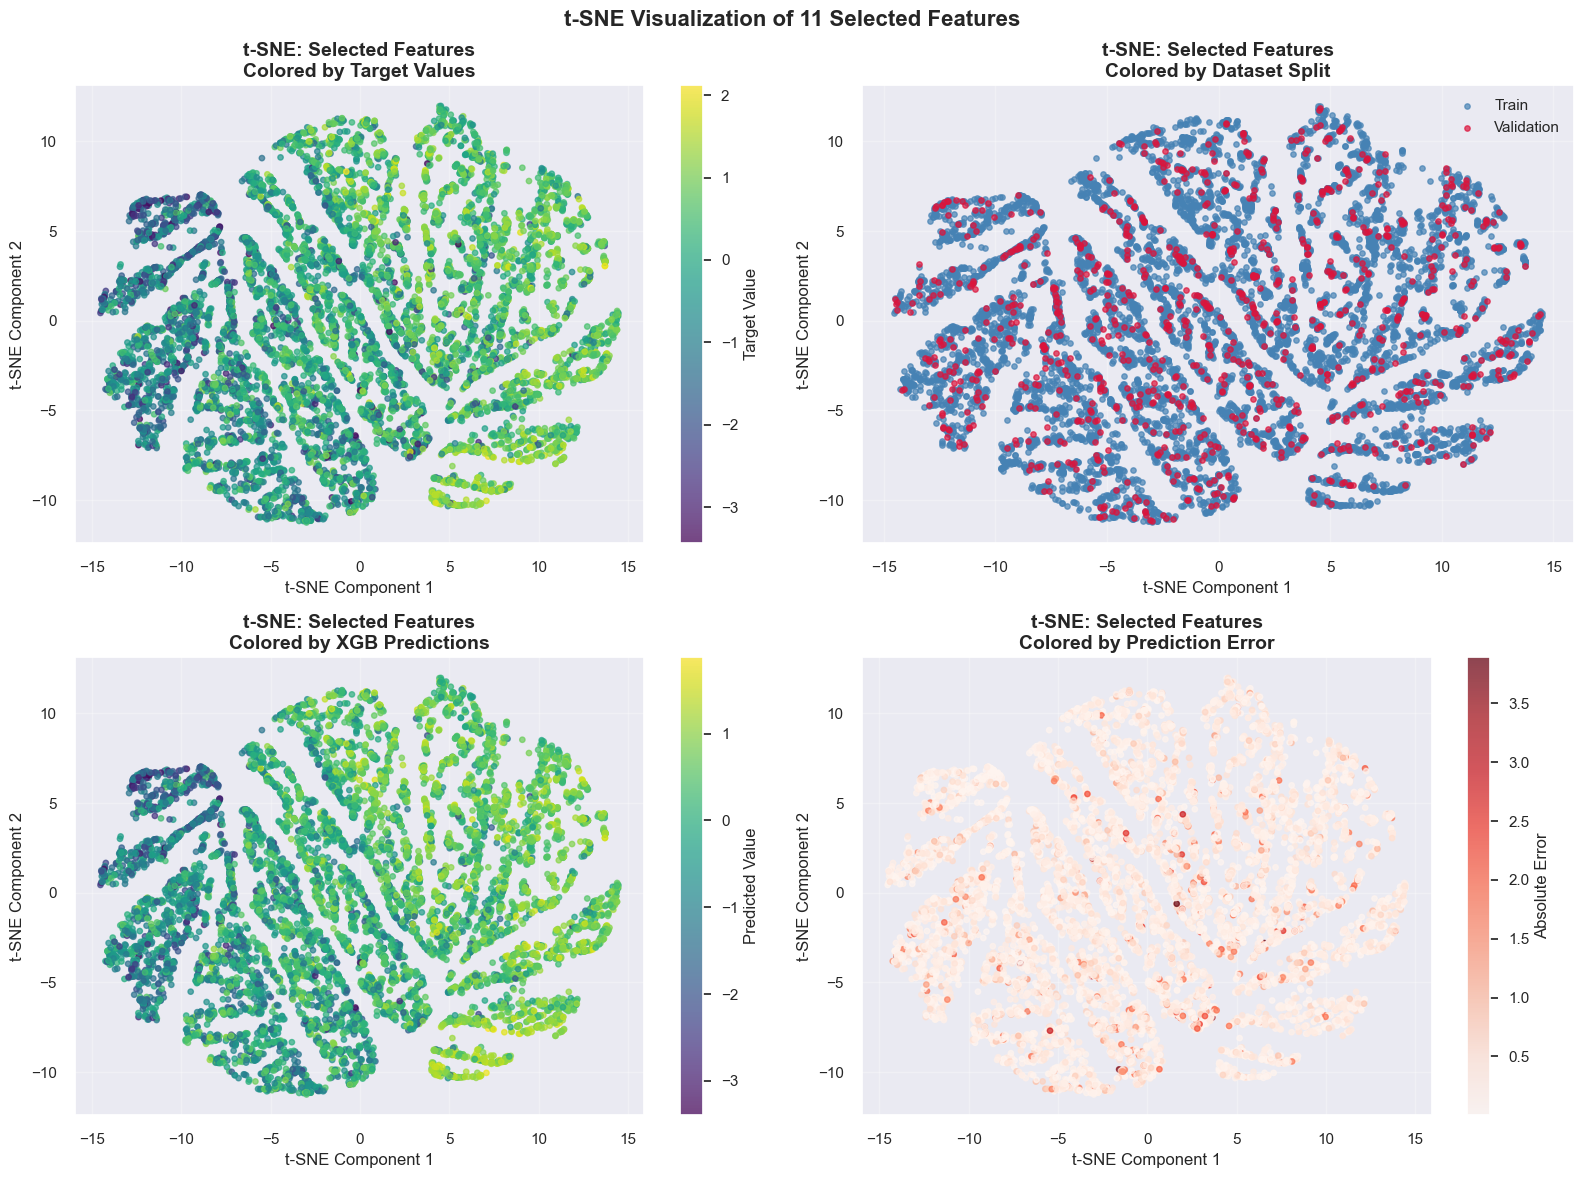


Data Statistics:
Target range: [-3.440, 2.123]
Prediction range: [-3.398, 1.882]
Error range: [0.000, 3.894]
Mean absolute error: 0.2324


In [44]:
# t-SNE Visualization of Selected Features
print("\nt-SNE Visualization of Selected Features")
print("=" * 40)

# Combine train and validation data
all_features = np.concatenate([X_final_train, X_final_val], axis=0)
all_targets = np.concatenate([y_train, y_val], axis=0)
all_predictions = np.concatenate([y_train_pred, y_val_pred], axis=0)
dataset_labels = ['Train'] * len(X_final_train) + ['Val'] * len(X_final_val)

print(f"Combined features shape: {all_features.shape}")
print(f"Selected features: {selected_features}")

# Apply t-SNE
from sklearn.manifold import TSNE
print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
features_2d = tsne.fit_transform(all_features)
print(f"t-SNE completed. Shape: {features_2d.shape}")

# Calculate absolute errors
absolute_errors = np.abs(all_predictions - all_targets)

# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Colored by target values
scatter1 = ax1.scatter(features_2d[:, 0], features_2d[:, 1], 
                      c=all_targets, cmap='viridis', alpha=0.7, s=15)
ax1.set_title(f't-SNE: Selected Features\nColored by Target Values', fontsize=14, fontweight='bold')
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Target Value')

# Plot 2: Colored by dataset split
train_mask = np.array(dataset_labels) == 'Train'
val_mask = np.array(dataset_labels) == 'Val'
ax2.scatter(features_2d[train_mask, 0], features_2d[train_mask, 1], 
           c='steelblue', alpha=0.7, s=15, label='Train')
ax2.scatter(features_2d[val_mask, 0], features_2d[val_mask, 1], 
           c='crimson', alpha=0.7, s=15, label='Validation')
ax2.set_title(f't-SNE: Selected Features\nColored by Dataset Split', fontsize=14, fontweight='bold')
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Colored by predictions
scatter3 = ax3.scatter(features_2d[:, 0], features_2d[:, 1], 
                      c=all_predictions, cmap='viridis', alpha=0.7, s=15)
ax3.set_title(f't-SNE: Selected Features\nColored by {best_regressor_name} Predictions', fontsize=14, fontweight='bold')
ax3.set_xlabel('t-SNE Component 1')
ax3.set_ylabel('t-SNE Component 2')
ax3.grid(True, alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=ax3)
cbar3.set_label('Predicted Value')

# Plot 4: Colored by absolute error
scatter4 = ax4.scatter(features_2d[:, 0], features_2d[:, 1], 
                      c=absolute_errors, cmap='Reds', alpha=0.7, s=15)
ax4.set_title(f't-SNE: Selected Features\nColored by Prediction Error', fontsize=14, fontweight='bold')
ax4.set_xlabel('t-SNE Component 1')
ax4.set_ylabel('t-SNE Component 2')
ax4.grid(True, alpha=0.3)
cbar4 = plt.colorbar(scatter4, ax=ax4)
cbar4.set_label('Absolute Error')

plt.suptitle(f't-SNE Visualization of {len(selected_features)} Selected Features', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print statistics
print(f"\nData Statistics:")
print(f"Target range: [{all_targets.min():.3f}, {all_targets.max():.3f}]")
print(f"Prediction range: [{all_predictions.min():.3f}, {all_predictions.max():.3f}]")
print(f"Error range: [{absolute_errors.min():.3f}, {absolute_errors.max():.3f}]")
print(f"Mean absolute error: {absolute_errors.mean():.4f}")